Tak jak rozmawialiśmy to jest jedynie bardzo początkowe przejrzenie tych metod (dalej tej Doc2Vec wygląda dość dziwnie), ale przynajmniej wstępne wyniki wyglądają jakby miało to jakiekolwiek szanse zadziałać :D

Sekwencja czynności przy framework'u **WL**:
1. wczytanie grafu przy założeniu, że feature'ami będą stopnie wierzchołków;
2. na podstawie stopni wierzchołków i ich sąsiadów, generujemy nowe charakterystyki $\rightarrow$ "podobny label" mają wierzchołki, które są podobnego stopnia i ich sąsiedzi są podobnych stopni;
3. na podstawie listy nowoutworzonych cech tworzona jest instancja klasy `TaggedDocument`, gdzie tagiem jest nazwa grafu;
4. utworzony w kroku $3.$ dokument podawany jest na wejściu `Doc2Vec'a`.

References:
- https://docs.cogdl.ai/en/latest/_modules/cogdl/models/emb/graph2vec.html
- https://towardsdatascience.com/beyond-weisfeiler-lehman-approximate-isomorphisms-and-metric-embeddings-f7b816b75751

In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
import json
import glob

import numpy as np
import pandas as pd
import networkx as nx

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut
from sklearn.linear_model import LogisticRegression

from IPython.display import Markdown, display
from tqdm.notebook import tqdm

from karateclub.graph_embedding.graph2vec import Graph2Vec

sys.path.append("../")
from src.graph2vec import OurGraph2Vec, Ensemble_G2V
from src.utils import read_stargazers_dataset,cross_validate, calculate_measure

plt.rcParams["figure.figsize"] = (16, 8)

In [2]:
graphs, labels = read_stargazers_dataset("../datasets/github_stargazers")

len(graphs)

12725

In [3]:
def weighted_mean(alpha: float):
    return lambda x, y: alpha * x + (1 - alpha) * y


def select_by_var(arr: np.array, alpha: float):
    variances_ord = np.var(arr, axis=0).argsort()[::-1]
    return arr[:, variances_ord][:, : int(alpha * arr.shape[1])]


def by_weighted_variance(alpha: float):
    return lambda x, y: np.concatenate(
        (select_by_var(x, alpha), select_by_var(y, 1 - alpha)), axis=1
    )

## Parameters section

In [4]:
subset_card = len(graphs)  # number of graphs
cross_val_k = 13  # number of folds to perform in cross-validation (could be int or LeaveOneOut())

In [5]:
MEASURES = [
    nx.pagerank,
    nx.closeness_centrality,
    # nx.degree_centrality,
    nx.current_flow_closeness_centrality,
    # nx.information_centrality,  # identical to: current_flow_closeness_centrality
    # nx.betweenness_centrality,
    # nx.current_flow_betweenness_centrality, #too long (50 minutes :'( )
    # nx.approximate_current_flow_betweenness_centrality,
]

KWARGS_DICT = {
    nx.pagerank: {},
    nx.closeness_centrality: {},
    nx.degree_centrality: {},
    nx.current_flow_closeness_centrality: {},
    # nx.information_centrality: {},
    nx.betweenness_centrality: {},
    nx.current_flow_betweenness_centrality: {},
    nx.approximate_current_flow_betweenness_centrality: {},
}

In [6]:
tested_range = np.linspace(0, 1, 26)
WEIGHTING_FUNCTIONS = (
    {f"w_m_{a}": weighted_mean(a) for a in tested_range}
    | {f"w_v_{a}": by_weighted_variance(a) for a in tested_range}
    | {f"concat": lambda x, y: np.concatenate((x, y), axis=1)}
)

## Execution section

In [7]:
graphs_subset = graphs[:subset_card]

reference_model=Graph2Vec()
without = OurGraph2Vec()  # without
without_orig= OurGraph2Vec()
with_orig= OurGraph2Vec(cbowlike=True)
with_dm = OurGraph2Vec(cbowlike=True)  # with_dm (experiment)
ens_model = Ensemble_G2V(without, with_dm)
ens_orig=Ensemble_G2V(without_orig, with_orig)

In [8]:
# in this cell, we create a dictionary of orders with the following structure:
# order_dict = {
#    measure.__name__: nested list of nodes sorted wrt. measure
# }
order_dict = {}

for measure in tqdm(MEASURES):
    # centralities calc.
    print(f"Calculating {measure.__name__}...")

    centralities = [None] * subset_card
    for idx, G in tqdm(enumerate(graphs_subset), total=subset_card):
        centralities[idx] = calculate_measure(
            func=measure, G=G, kwargs=KWARGS_DICT[measure]
        )

    # ordering wrt. centralities
    print(f"Ordering wrt. {measure.__name__}...")
    ams = [None for i in range(subset_card)]

    for it, central_dict in tqdm(enumerate(centralities), total=subset_card):
        ams[it] = np.array(sorted(central_dict, key=central_dict.get), dtype=np.int64)

    order_dict[measure.__name__] = ams

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating pagerank...


  0%|          | 0/12725 [00:00<?, ?it/s]

Ordering wrt. pagerank...


  0%|          | 0/12725 [00:00<?, ?it/s]

Calculating closeness_centrality...


  0%|          | 0/12725 [00:00<?, ?it/s]

Ordering wrt. closeness_centrality...


  0%|          | 0/12725 [00:00<?, ?it/s]

Calculating current_flow_closeness_centrality...


  0%|          | 0/12725 [00:00<?, ?it/s]

<class 'networkx.utils.decorators.argmap'> compilation 20:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


Ordering wrt. current_flow_closeness_centrality...


  0%|          | 0/12725 [00:00<?, ?it/s]

In [9]:
np.save("../datasets/github_stargazers/orderings.npy",order_dict)
order_dict=np.load("../datasets/github_stargazers/orderings.npy",allow_pickle=True)[()]

  0%|          | 0/3 [00:00<?, ?it/s]

'pagerank'

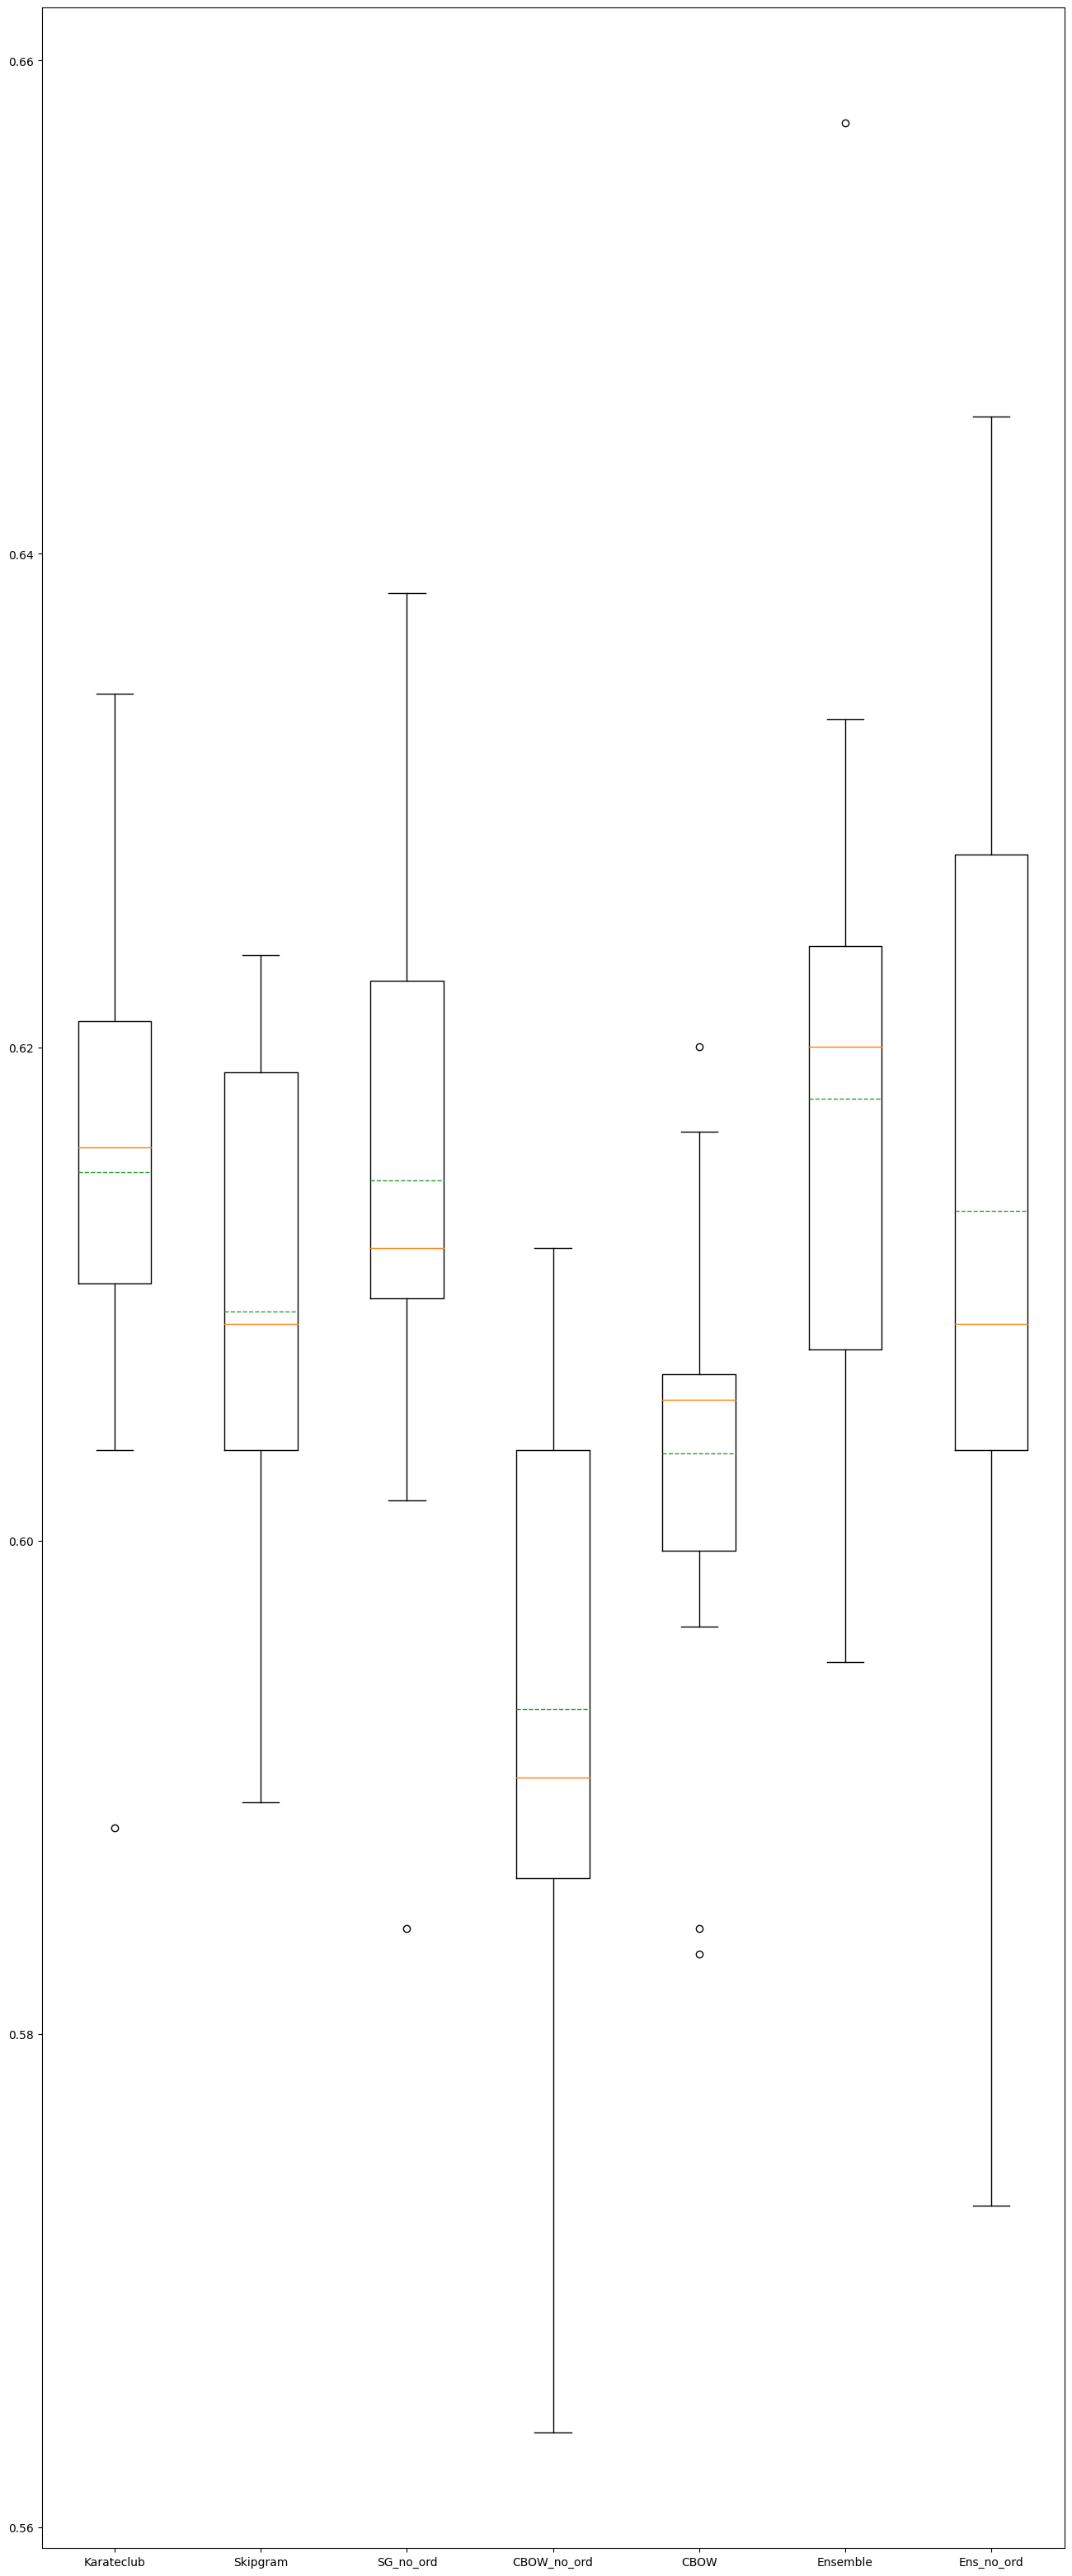

'closeness_centrality'

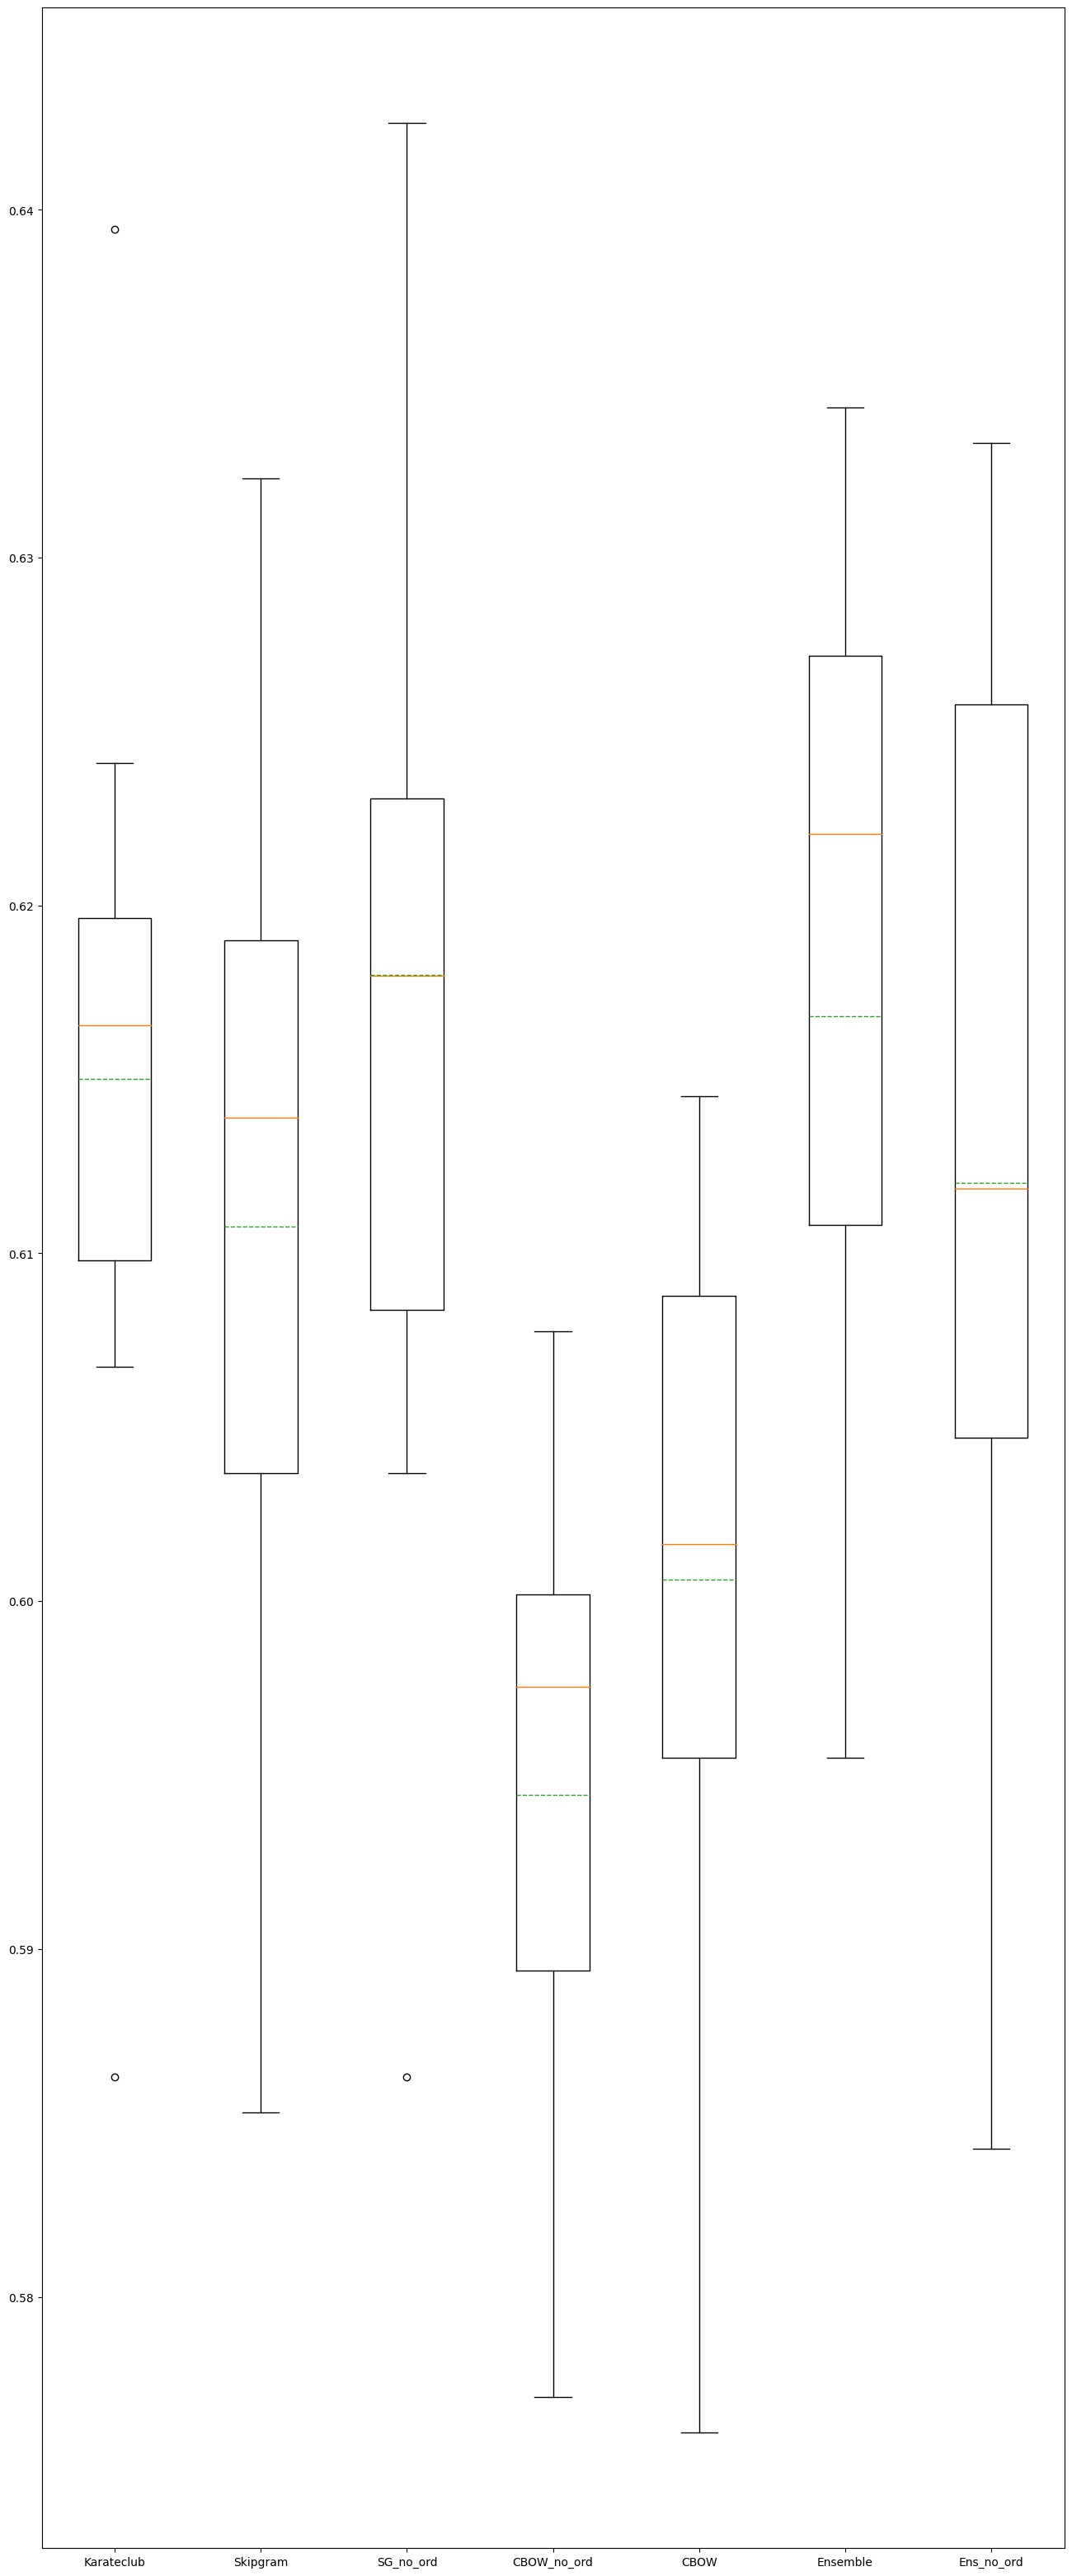

'current_flow_closeness_centrality'

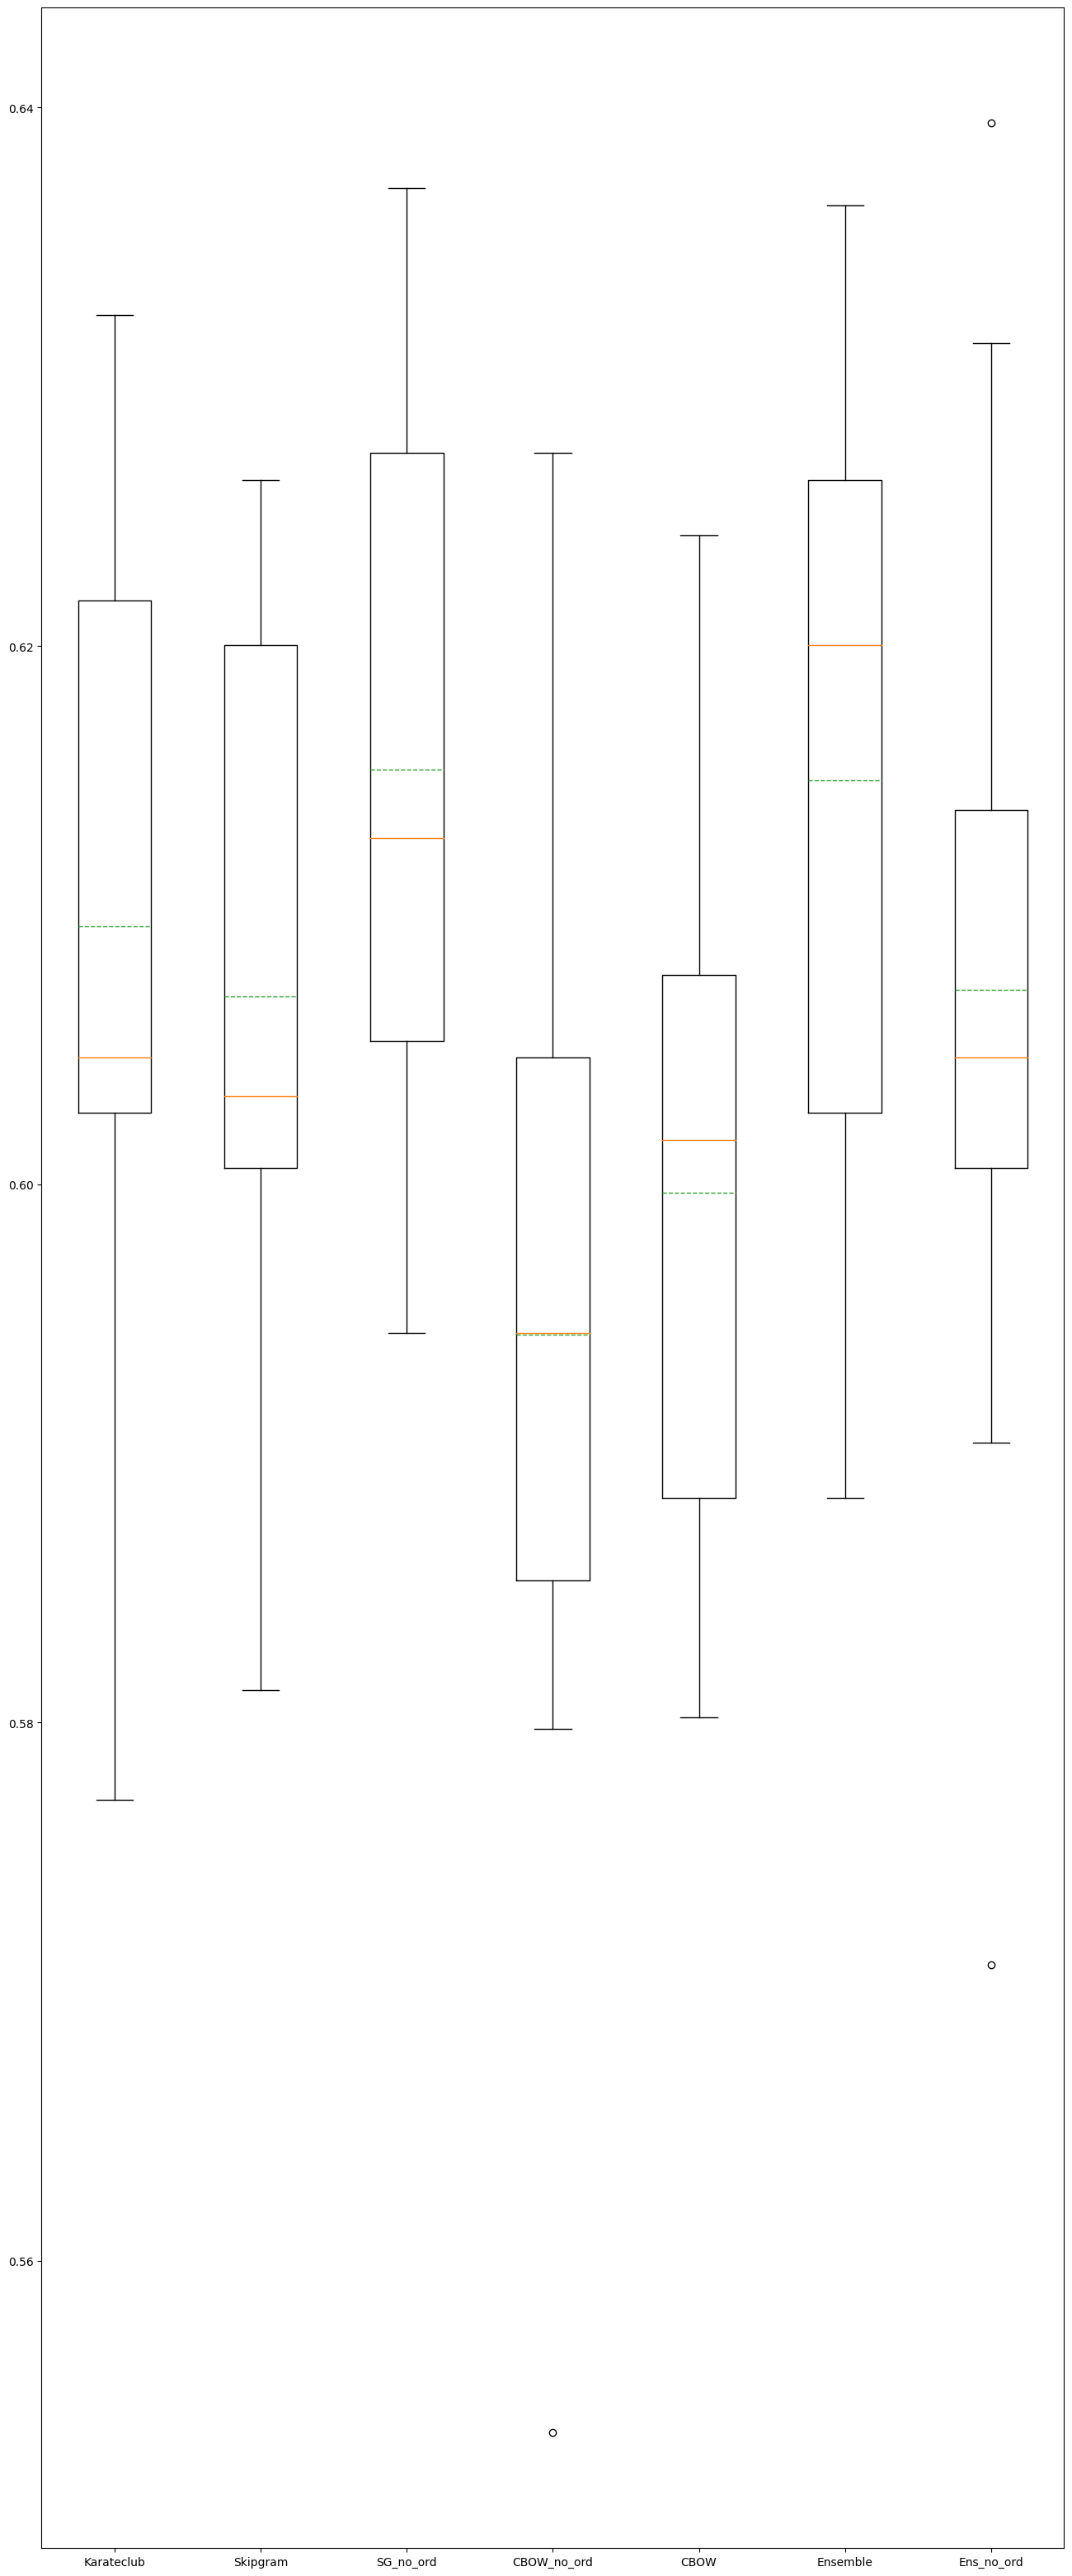

In [18]:
# in this cell we run experiments for all measures

for measure, order in tqdm(order_dict.items()):
    display(measure)

    # benchmark
    reference_model.fit(graphs_subset)
    without.fit(graphs_subset, orderings=order)
    without_orig.fit(graphs_subset, orderings=None)
    with_orig.fit(graphs_subset, orderings=None)
    with_dm.fit(graphs_subset, orderings=order)
    ens_model.fit(graphs_subset, orderings=order)
    ens_orig.fit(graphs_subset,orderings=None)

    # experiment    
    ref_res = cross_validate(reference_model.get_embedding(), labels,LogisticRegression(max_iter=1000), cv=cross_val_k)
    no_dm_res = cross_validate(without.get_embedding(), labels, LogisticRegression(max_iter=1000), cv=cross_val_k)
    no_dm_no_ord_res=cross_validate(without_orig.get_embedding(), labels, LogisticRegression(max_iter=1000), cv=cross_val_k)
    dm_no_ord_res=cross_validate(with_orig.get_embedding(), labels, LogisticRegression(max_iter=1000), cv=cross_val_k)
    dm_res = cross_validate(with_dm.get_embedding(), labels, LogisticRegression(max_iter=1000), cv=cross_val_k)
    ens_res = cross_validate(ens_model.get_embedding(), labels, LogisticRegression(max_iter=1000), cv=cross_val_k)
    ens_orig_res=cross_validate(ens_orig.get_embedding(), labels, LogisticRegression(max_iter=1000), cv=cross_val_k)

    # results
    res_nested_list = [ref_res,no_dm_res, no_dm_no_ord_res,dm_no_ord_res,dm_res, ens_res,ens_orig_res]
    axis_labels = ["Karateclub","Skipgram","SG_no_ord", "CBOW_no_ord", "CBOW", "Ensemble","Ens_no_ord"]

    n_items = len(res_nested_list)
    plt.boxplot(res_nested_list, positions=range(n_items), showmeans=True,meanline=True)
    plt.xticks(range(n_items), labels=axis_labels[:n_items])
    plt.show()

### Evaluating the model's performance via k-fold cross-validation

In [11]:
plt.rcParams["figure.figsize"] = (16, 40)

In [12]:
for it,el in enumerate(order_dict['closeness_centrality']):
    if len(el)!=graphs_subset[it].number_of_nodes():
        print(len(el),graphs_subset[it].number_of_nodes())

  0%|          | 0/3 [00:00<?, ?it/s]

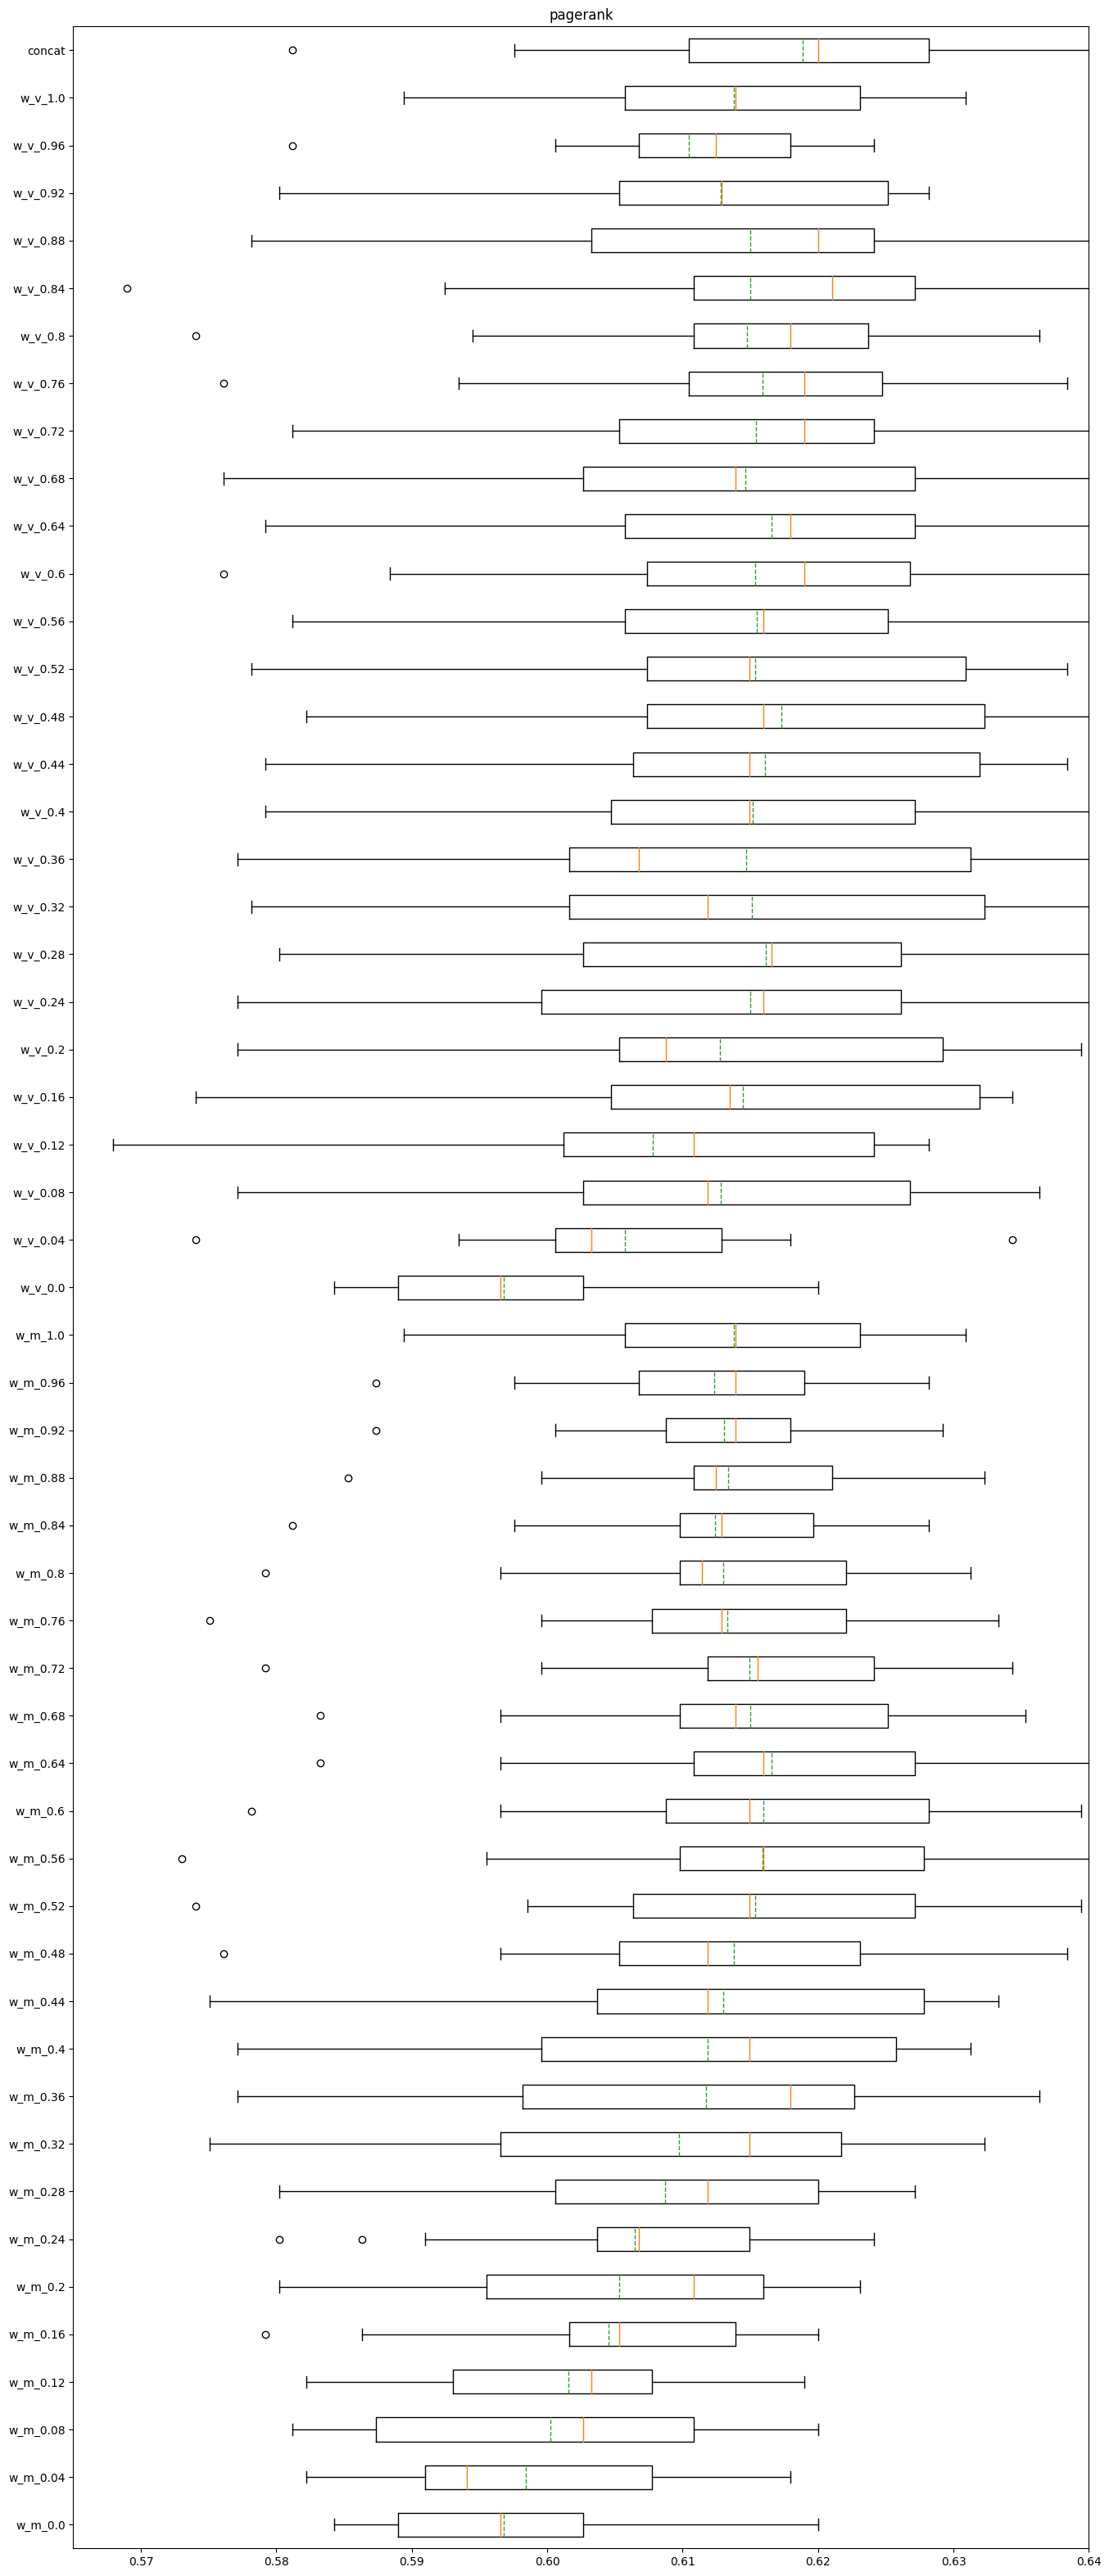

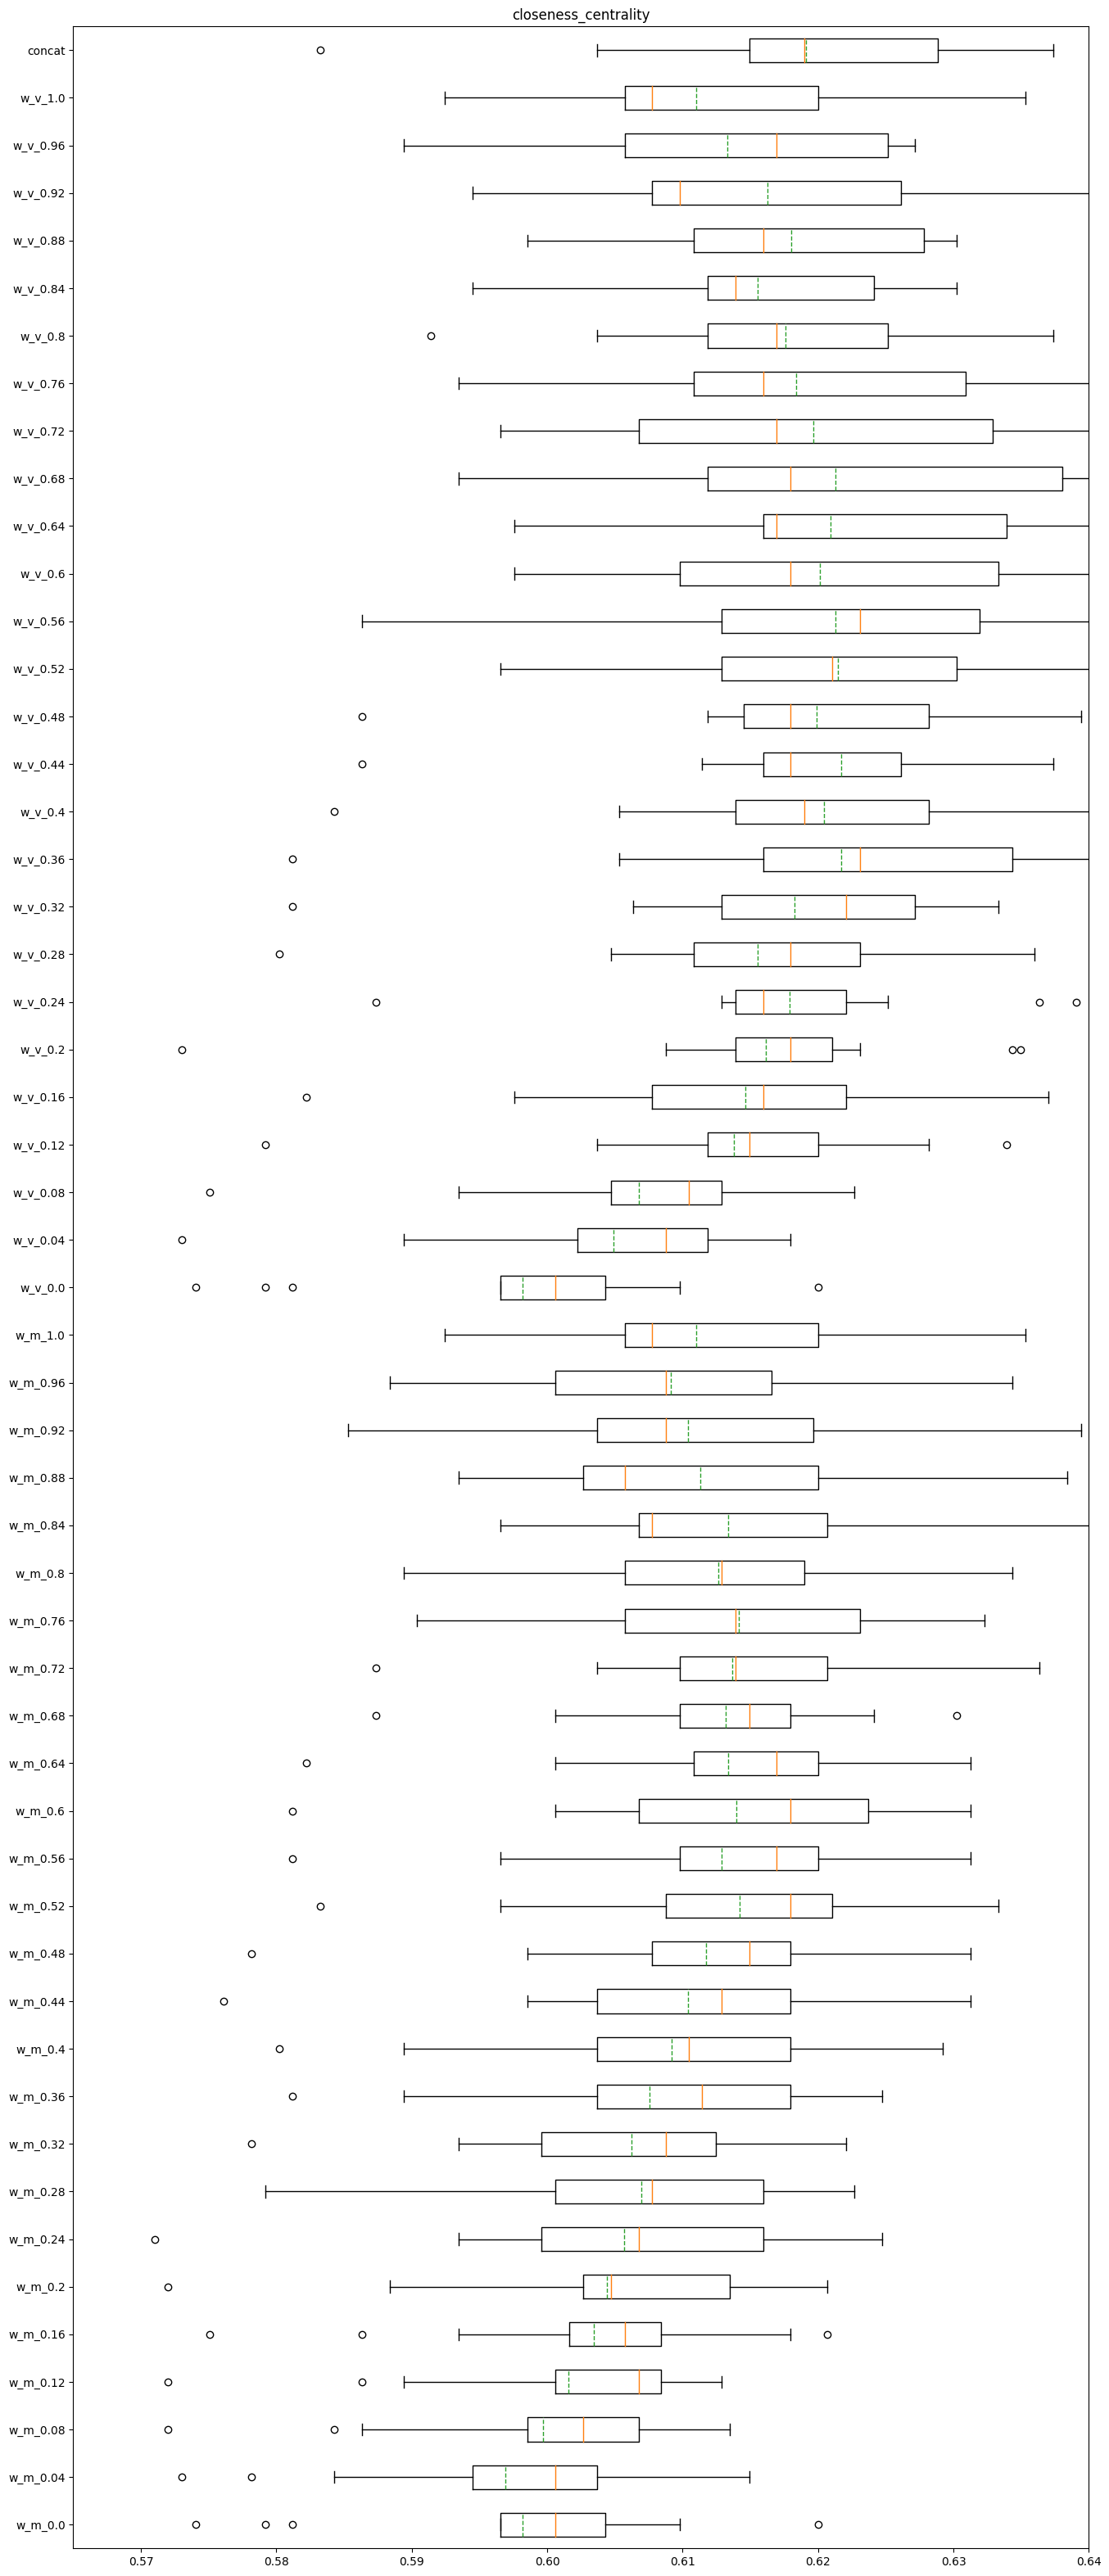

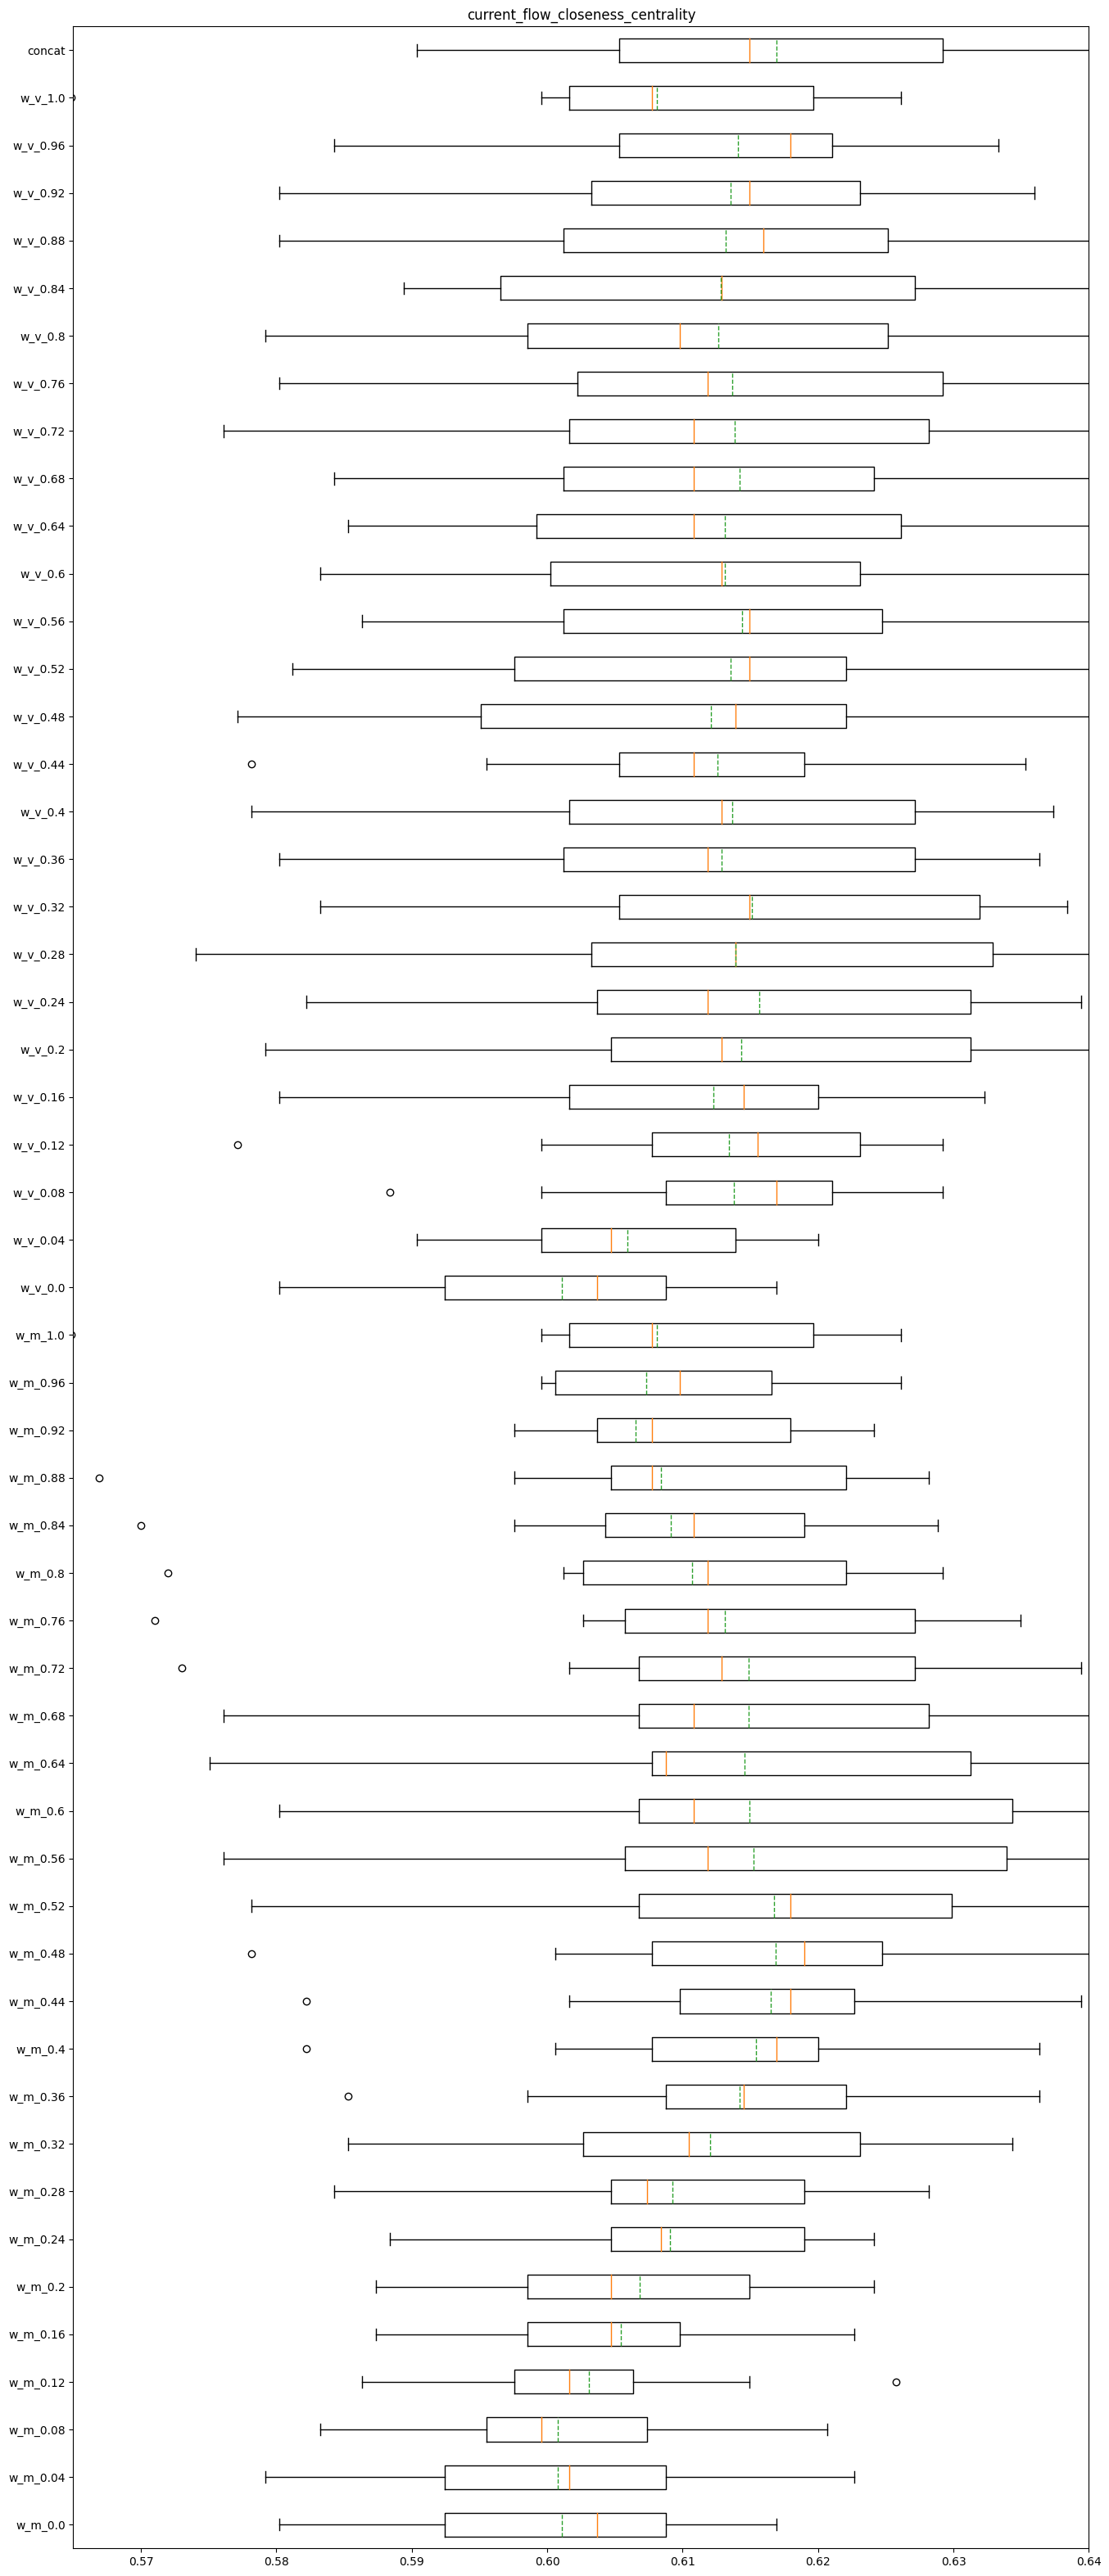

In [17]:
for measure, order in tqdm(order_dict.items()):
    res = {}
    without.fit(graphs_subset, orderings=order)
    with_dm.fit(graphs_subset, orderings=order)
    for name, func in WEIGHTING_FUNCTIONS.items():
        ens_model.set_weighting_function(func)
        res[name] = cross_validate(ens_model.get_embedding(), labels,LogisticRegression(max_iter=1000), cv=cross_val_k)
    n_items = len(res)
    plt.title(measure)
    plt.boxplot(res.values(), positions=range(n_items), vert=False, showmeans=True,meanline=True)
    plt.yticks(range(n_items), labels=res.keys())
    plt.xlim([0.565, 0.64])
    plt.show()

Od Łukasza: Może rzutowanie PCA i wtedy zrobienie średniej? Rotacja minimalizująca sumę odległości między elementami, warto mieć 1 syntetyczny :D